# ASTRON C161 Final Project
---
* Notes
    * Coordinate conversion: 1 coordinate corresponds to a distance of 3e8 meters

In [232]:
conversion = 3e8 # One pixel corresponds to 3e8 meters, which was calculated based on the tidal radius

In [233]:
import numpy as np
from scipy import constants as consts
import matplotlib.pyplot as plt
from matplotlib.animation import FFMpegWriter
metadata = dict(title='Simulation', artist='Matplotlib',comment='Oh my')
writer = FFMpegWriter(fps=15, metadata=metadata)

## 1) Setting Up
---

### 1.1: Defining constants

In [234]:
# Constants
G = consts.G
c = consts.c
solar_radius = 6.957e8
solar_mass = 1.989e30
bh_mass = 5*solar_mass # can change this later

### 1.2: Useful functions + classes

In [235]:
def to_cart(r, theta, convert=True):
    '''Convert set of polar coordinates to cartesian
    The conversion parameter automatically assumes 
    that you need to convert the pixel units
    and will divide the r values by 3e8'''
    global conversion
    if convert:
        r = np.copy(r)
        r/=conversion
    return r*np.cos(theta), r*np.sin(theta)

def to_polar(x, y):
    '''Convert polar coordinates to cartesian'''
    return np.sqrt(x**2 + y**2), np.arctan(y/x)

def sch_radius(M):
    '''Calculate the schwarzchild radius for a given M mass black hole'''
    global G, c
    return 2*G*M / c**2

def tidal_radius(m, M, r_star):
    '''Calculate the tidal radius, given a star and a black hole'''
    return (M/m)**(1/3) * r_star

def calc_dr_dtau(E, L, r, m=solar_mass, M=bh_mass):
    '''Calculate dr/dtau'''
    rs = sch_radius(M)
    p1 = E**2 / (m**2 * c**2)
    p2 = (L**2 / (m**2 * r**2)) * (1-(rs/r))
    p3 = c**2 * (1-(rs/r))
#     print(p1, p2, p3)
    return (p1-p2-p3)**(0.5)

def energy(v, r, m, M):
    global G
    return 0.5*m*v**2 - G*M*m/r
    
def ang_momentum(m, v, b):
    return m*v*b

def scale_up(rs):
    global conversion
    return np.copy(rs) * conversion

## 2) Initialization of Variables
---

Get the tidal radius via $r_T = (\frac{M_{\text{bh}}}{M_{\text{star}}})^{1/3} R_{\text{star}}$

In [236]:
dtau = 0.1
rt = tidal_radius(solar_mass, bh_mass, solar_radius)

Swarm initiation

In [237]:
N_swarm = 100000 # number of swarm particles
b = rt + (0.1*rt) # impact parameter, a little bigger than tidal radius
swarm = np.random.uniform(rt-solar_radius, rt+solar_radius, N_swarm-1)

# Initial coordinates of the star in cartesian (b/c it's easier to work with)
np.random.seed(2023)
rs = np.append(b, swarm) # an array of starting radius (r) positions
init_xs = rs/conversion
init_ys = np.random.uniform(-solar_radius/conversion, solar_radius/conversion, N_swarm)

# Edit the star so that it's a circle, like in Burkhard's class
circle = lambda x, y, r: np.sqrt((x-(rt/conversion))**2 + y**2) <= r
idxs = np.where(circle(init_xs,init_ys,solar_radius/conversion))[0]
init_xs = init_xs[idxs]
init_ys = init_ys[idxs]

rs, phis = to_polar(init_xs, init_ys)
rs = scale_up(rs)

### 2.1: Angular momentum and $\frac{d\phi}{d\tau}$
* $L = mvb$
* $\frac{d\phi}{d\tau} = \frac{L}{mr^2}$

In [238]:
m = solar_mass
M = bh_mass
b = rt + (0.1*rt) # impact parameter, a little bigger than tidal radius
v = 1.595e9

L = ang_momentum(m,v,b)

dphi_dtau = L / (m*b**2)
dphi = dphi_dtau * dtau
dphi

1.2188660975732803

### 2.2: Energy and $\frac{dr}{d\tau}$

In [239]:
r = b
E = energy(v, r, m, M)
dr_dtau = calc_dr_dtau(E, L, rt)
0.5*m*v**2 - G*M*m/r
dr_dtau/conversion

12.838627876659338

In [240]:
E = energy(v, rs, m, M)
dr_dtau = calc_dr_dtau(E, L, rs)
dr = dr_dtau * dtau / conversion
dr

array([13.10511178, 13.21557076, 13.60523321, ..., 13.22573374,
        4.61861418, 12.97272923])

### Test simulation with only $\frac{d\phi}{d\tau}$

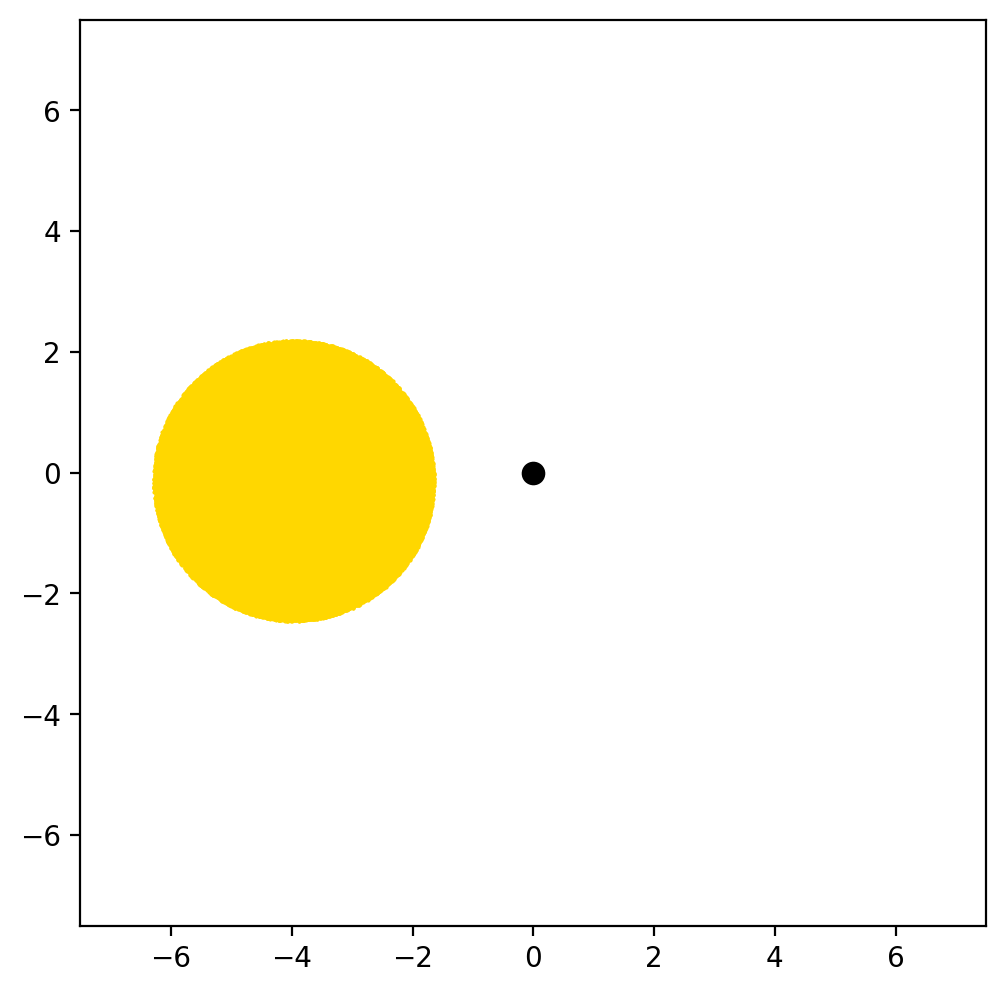

In [241]:
fig = plt.figure(figsize=(12.,6.), dpi=200)
view = 7.5

with writer.saving(fig, "test5.mp4", dpi=200):
    for i in range(50):
        # Update graph
        plt.clf()
        x, y = to_cart(rs, phis)
        plt.plot(x, y, '.', markersize=1, color='gold')
        plt.plot(0, 0, '.', markersize=15, color='black')
        plt.xlim(-view,view)
        plt.ylim(-view,view)
        plt.gca().set_aspect('equal')
        # Update coordinates
        phis += dphi
        E = energy(v, rs, m, M)
        dr_dtau = calc_dr_dtau(E, L, rs)
        dr = dr_dtau * dtau / conversion
        rs += dr
        # Update animation
        writer.grab_frame()

```python
r = np.arange(0, 2, 0.01)
theta = 2 * np.pi * r
fig = plt.figure(figsize=(12.,6.), dpi=200)

with writer.saving(fig, "test2.mp4", dpi=200):
    for i in range(len(r)):
        plt.clf()
        x, y = cart(r[i], theta[i])
        plt.plot(x, y, '.')
        plt.xlim(-3,3)
        plt.ylim(-3,3)
        plt.grid(True)
        writer.grab_frame()
```